In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython.display import clear_output
import seaborn as sns

import cPickle as pk
import pandas as pd
import networkx as nx
import scipy.sparse as sp
import itertools as itls
from itertools import combinations
import numpy as np
from math import sqrt

import sys

## Importing
[to top](#Table-of-Contents) 

In [4]:
pwd

u'/Users/innovation-sfi/Dropbox/Research/Innovation/EPO/Data_processing/Python'

In [5]:
df = pk.load(open('pickles_and_munged_csv/pre1950_cated_cumed_codes_as_ints_v1.pk', 'rb')); df.head()

appln_auth,AT,AU,BE,CA,CH,DE,DK,ES,FI,FR,...,IE,IS,IT,JP,LU,NL,NO,SE,SU,US
pub_year,,,,,,,,,,,,,,,,,,,,,
1836,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[1513, 1789], [1268, 1855], [1762, 1821], [24..."
1837,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[5834, 5836], [4907, 5440], [799, 5648], [602..."
1838,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[1537, 1774], [1154, 1208], [2724, 2748], [40..."
1839,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[4212, 4231], [5078, 6180], [4915, 5001], [33..."
1840,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[2722, 2748], [1862, 1862], [1161, 5985], [48..."


In [14]:
s_US = df.US

In [16]:
del df

In [15]:
s_US

pub_year
1836    [[1513, 1789], [1268, 1855], [1762, 1821], [24...
1837    [[5834, 5836], [4907, 5440], [799, 5648], [602...
1838    [[1537, 1774], [1154, 1208], [2724, 2748], [40...
1839    [[4212, 4231], [5078, 6180], [4915, 5001], [33...
1840    [[2722, 2748], [1862, 1862], [1161, 5985], [48...
1841    [[5986, 6001], [3027, 5586], [2964, 3002], [18...
1842    [[4897, 5004], [5740, 5803], [5349, 5421], [11...
1843    [[1762, 1821], [1762, 1821], [5704, 5807], [57...
1844    [[3764, 3825], [1520, 1764], [4641, 4643], [11...
1845    [[5318, 5404], [1060, 4759], [3969, 4052], [23...
1846    [[4097, 6441], [5610, 6516], [1204, 1758], [17...
1847    [[4097, 6441], [1816, 1817], [1722, 5438], [17...
1848    [[335, 2889], [4315, 4750], [5471, 5479, 5479]...
1849    [[5479, 5479], [1496, 1622], [1237, 5473], [50...
1850    [[1754, 1764], [659, 813], [1513, 1789], [1848...
1851    [[327, 332], [4810, 5731], [1829, 1853], [5740...
1852    [[5687, 6199], [4898, 4929], [110, 1211], [489...
1853 

# AdjM building

In [17]:
def make_match_node_AdjDfs(df1, df2):
    
    # assumes dfs are symmetric and square
    # should implement a check here...
    
    # get union of dataframe indexes
    inx_1 = df1.index
    inx_2 = df2.index
    inx_un = inx_1.union(inx_2)
    
    # reindex both index and columns filling with 0
    df1 = df1.reindex(index=inx_un, fill_value=0).reindex(columns=inx_un, fill_value=0)
    df2 = df2.reindex(index=inx_un, fill_value=0).reindex(columns=inx_un, fill_value=0)
    
    return df1, df2

# DeltaCon

In [62]:
def compute_FBP_invs(A):

    # max power to calculate inverse to
    max_pw = 7

    # make identity
    I = sp.identity(A.shape[0])
 
    # remove self links - can't propogate beliefs to self - need to consider if the self links should be counted in
    # degree still?
    A = A - sp.dia_matrix((A.diagonal(), [0]),
                                    shape=(A.shape[0], A.shape[0]))

    # make degree matrix
    ds = [int(x) for x in A.sum(axis=1)]
    D = sp.dia_matrix((ds, [0]),
                     shape=(len(ds), len(ds)))
    
    # compute about-half homophility factor that gaurentees convergences of W power series
    c1 = D.sum() + 2
    c2 = np.dot(D,D).sum() - 1 
    h_h = sqrt((-c1+sqrt(c1**2 + 4*c2))
               /(8*c2)
              )
    
    # compute system constants ah (from ahD) and ch from (achA)
    ah = 4*(h_h**2) /(1-4*(h_h**2))
    ch = 2*h_h / (1-4*(h_h**2))
    
    # create matrix M to form (I - M)^-1
    M = ch*A - ah*D
    
    # expand to power series to compute inverse
    inv = I
    mat = M
    pwr = 1
    while mat.data[mat.data.argmax()] > 10**(-9) and pwr < max_pw:
        inv = inv + mat
        mat = mat * M
        pwr = pwr + 1
    return inv

In [63]:
def DeltaCon(A1, A2):
    
    # quick return for identical networks
    if (A1 != A2).nnz == 0:
        print 'Iden'
        return 1.0
    
    # initialize
    # prior belief for nodes (doesn't really affect results of deltacon says paper)
    # BUT it massively effects the results!!!!!!!
    # the closer to 0.5, the greater the dampening on differences
    p = 0.51
    
    # Solve the linear BP systems (FaBP): inv corresponds to [I + ah*D - ch*A]^-1
    # and multiple by about-half prior beliefs
    inv1 = compute_FBP_invs(A1) * (p-0.5)
    inv2 = compute_FBP_invs(A2) * (p-0.5)
    
    # compute the similarities using Matusita distance
    diffM = (inv1.sqrt() - inv2.sqrt())
    diffM = diffM.multiply(diffM)
    
    # delete diagonal entries -  the influence nodes have on themselves
    diffM = diffM - sp.dia_matrix((diffM.diagonal(), [0]), shape=(diffM.shape[0], diffM.shape[0]))

    return 1 / (1 + sqrt(diffM.sum()))

# Applying

In [1]:
# initialise 
years = range(1990,2001)

[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000]


In [44]:
#create inital Adf
g1 = nx.MultiGraph()
for ls in s_US.loc[years[0]]:
    g1.add_edges_from(combinations(ls, 2))
Adf1 = nx.to_pandas_dataframe(g1)

for year in years[1:]:
    
    print year, # progress reporting
    
    #create Adf for the next year
    g2 = nx.MultiGraph()
    for ls in s_US.loc[year]:
        g2.add_edges_from(combinations(ls, 2))
    Adf2 = nx.to_pandas_dataframe(g2)
    
    # expand and sort dataframes to match
    Adf1, Adf2 = make_match_node_AdjDfs(Adf1, Adf2)
    
    #add sim value between years
    s_US_sims.loc[year] = DeltaCon(sp.csr_matrix(Adf1.values), sp.csr_matrix(Adf2.values))
    
    #set the inital Adf as the subsequent one, ready for next loop
    Adf1 = Adf2 

 1960 1970 1980 1990 2000 2010


In [45]:
who

Adf1	 Adf2	 DeltaCon	 clear_output	 combinations	 compute_FBP_invs	 g1	 g2	 i	 
itls	 ls	 lsls_US_2010	 make_match_node_AdjDfs	 np	 nx	 pd	 pk	 plt	 
s_US	 s_US_sims	 sns	 sp	 sqrt	 sys	 year	 years	 


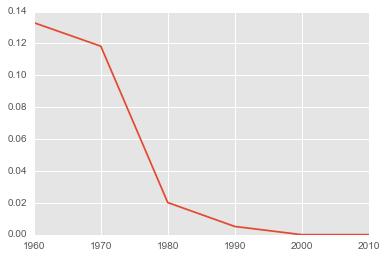

In [46]:
s_US_sims.plot()

In [47]:
s_US_sims2005_2010 = pd.Series()
years = range(2005,2011)

#create inital Adf
g1 = nx.MultiGraph()
for ls in s_US.loc[years[0]]:
    g1.add_edges_from(combinations(ls, 2))
Adf1 = nx.to_pandas_dataframe(g1)

for year in years[1:]:
    
    print year, # progress reporting
    
    #create Adf for the next year
    g2 = nx.MultiGraph()
    for ls in s_US.loc[year]:
        g2.add_edges_from(combinations(ls, 2))
    Adf2 = nx.to_pandas_dataframe(g2)
    
    # expand and sort dataframes to match
    Adf1, Adf2 = make_match_node_AdjDfs(Adf1, Adf2)
    
    #add sim value between years
    s_US_sims2005_2010.loc[year] = DeltaCon(sp.csr_matrix(Adf1.values), sp.csr_matrix(Adf2.values))
    
    #set the inital Adf as the subsequent one, ready for next loop
    Adf1 = Adf2 

2006 2007 2008 2009 2010


In [51]:
s_US_sims2005_2010

2006    0.000893
2007    0.001250
2008    0.001340
2009    0.001682
2010    0.001238
dtype: float64

In [58]:
s_US_sims2005_2010 = pd.Series()
years = range(2005,2011)

#create inital Adf
g1 = nx.MultiGraph()
for ls in s_US.loc[years[0]]:
    g1.add_edges_from(combinations(ls, 2))
Adf1 = nx.to_pandas_dataframe(g1)

for year in years[1:2]:
    
    print year, # progress reporting
    
    #create Adf for the next year
    g2 = nx.MultiGraph()
    for ls in s_US.loc[year]:
        g2.add_edges_from(combinations(ls, 2))
    Adf2 = nx.to_pandas_dataframe(g2)
    
    # expand and sort dataframes to match
    Adf1, Adf2 = make_match_node_AdjDfs(Adf1, Adf2)
    
    #add sim value between years
    s_US_sims2005_2010.loc[year] = DeltaCon(sp.csr_matrix(Adf1.values), sp.csr_matrix(Adf2.values))
    
    #set the inital Adf as the subsequent one, ready for next loop
    Adf1 = Adf2 

2006


In [60]:
s_US_sims2005_2010

2006    1
dtype: float64